In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error as MSE
import sklearn
import sklearn.gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from matplotlib.patches import Rectangle


import os
import warnings
import random
import ucb
import time
import math
import seaborn as sb

In [2]:
def min_max(spectra):
    scaler = sklearn.preprocessing.MinMaxScaler()
    return scaler.fit_transform(spectra.reshape(-1,1)).reshape(1,-1)[0]


def spectra_from_conc(action, RED, GREEN):
    """Transforms actions and input into output."""
    fract = normalize_to_fraction(action)
    spec = RED*action[0] + GREEN*action[1]
    return spec

def normalize_to_fraction(action):
    """Returns the fraction of total volume given the concentrations (action)."""
    total = np.sum(action)
    if total < .0001:
        return action * 0
    return action / total

class Environment(object):
    def __init__(self, target, RED, GREEN, BLUE):
        # in future this will be basis spectra
        self.target = target
        self.RED = RED
        self.GREEN = GREEN
        self.BLUE = BLUE
        self.metric = []
   
    def get_cos_sim(self, target, y):
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
    
    def sample(self, action):
        # put functins in utils python file
        result = spectra_from_conc(action, self.RED, self.GREEN)
        sim = self.get_cos_sim(self.target, result)
        mse = MSE(self.target, result)
        self.metric.append(sim)
        #return -mse*100
        return sim

In [3]:
sample_spectra = pd.read_excel('../../data/Sample_spectra.xlsx')
sample_spectra = np.asarray(sample_spectra)

In [4]:
wavelength = sample_spectra[:,0]
# spectra of base dyes
RED = sample_spectra[:,1]
GREEN = sample_spectra[:,2]
BLUE = sample_spectra[:,3]
#target_conc = np.random.dirichlet((1, 1), 1)[0]
target_conc = [.3, .7]
target_spectra = spectra_from_conc(target_conc, RED, GREEN)
target = target_spectra
    
env = Environment(target_spectra, RED, GREEN, BLUE)

batch_size = 4
epochs = 8

In [5]:
#constraints
min_conc = 0
max_conc = 1

# parameter space
N = 11 # grid size

# construct param space
coeffs = np.linspace(min_conc, max_conc, N)
param_space = np.meshgrid(coeffs, coeffs)


In [6]:
kernel = ConstantKernel(.5, constant_value_bounds="fixed") * RBF(.5, length_scale_bounds="fixed")
beta = 5

agent3 = ucb.BatchGPUCBv3(batch_size, param_space, env, beta=beta, kernel = kernel)
agent2 = ucb.BatchGPUCBv2(batch_size, param_space, env, beta=beta, kernel = kernel)
agent1 = ucb.BatchGPUCB(batch_size, param_space, env, beta=beta, kernel = kernel)

In [7]:
mu1 = [agent1.mu.reshape(len(coeffs),len(coeffs))]
mu2 = [agent2.mu.reshape(len(coeffs),len(coeffs))]
mu3 = [agent3.mu.reshape(len(coeffs),len(coeffs))]

sig1 = [agent1.sigma.reshape(len(coeffs),len(coeffs))]
sig2 = [agent2.sigma.reshape(len(coeffs),len(coeffs))]
sig3 = [agent3.sigma.reshape(len(coeffs),len(coeffs))]

elim = []
locs = []

for i in range(epochs):
    agent1.learn()
    mu1.append(np.flip(agent1.mu.reshape(len(coeffs),len(coeffs)), axis=0))
    sig1.append(np.flip(agent1.sigma.reshape(len(coeffs),len(coeffs)), axis=0))
    agent2.learn()
    mu2.append(np.flip(agent2.mu.reshape(len(coeffs),len(coeffs)), axis=0))
    sig2.append(np.flip(agent2.sigma.reshape(len(coeffs),len(coeffs)), axis=0))
    elim.append(agent3.learn())
    mu3.append(agent3.mu)
    sig3.append(agent3.sigma)
    locs.append(agent3.X_grid)

/Users/Will/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Will/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Will/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Will/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Will/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: User

In [12]:
print(locs[2])

[[0.2 0.7]
 [0.3 0.7]
 [0.4 0.7]
 [0.5 0.7]
 [0.6 0.7]
 [0.7 0.7]
 [0.2 0.8]
 [0.3 0.8]
 [0.4 0.8]
 [0.5 0.8]
 [0.6 0.8]
 [0.2 0.9]
 [0.3 0.9]
 [0.4 0.9]
 [0.5 0.9]
 [0.6 0.9]
 [0.  1. ]
 [0.1 1. ]
 [0.2 1. ]
 [0.3 1. ]
 [0.4 1. ]
 [0.5 1. ]
 [0.6 1. ]]


In [13]:
print(mu3[3]+sig3[3]*math.sqrt(beta))

[1.06842808 1.05881084 1.02653041 1.00421451 0.9923954  0.98806428
 1.0714524  1.0804356  1.05888502 1.03210362 1.00765862 1.05558866
 1.08103652 1.06537594 1.04113954 1.0276098  1.08564699 1.05593855
 1.07862425 1.08406956 1.0506534  0.99895405 1.03026905]


In [14]:
print(mu2[3]+sig2[3]*math.sqrt(beta))

[[1.08057903 1.05684573 1.06909966 1.06893321 1.03972053 0.99895405
  1.01406005 1.00963951 0.98055849 1.02138079 1.07945597]
 [1.0050755  0.96342923 1.05449671 1.08220789 1.07163638 1.04769781
  1.02424462 1.00765112 1.00342351 0.99724741 1.00652344]
 [0.97971268 1.01718129 1.07831654 1.09144615 1.07551415 1.04821481
  1.01370929 0.97436652 0.99700485 0.99581799 0.94273932]
 [0.95795774 1.02598841 1.06966367 1.06416617 1.04312498 1.02695059
  1.00708775 0.99307208 1.00020832 0.99585074 0.95593501]
 [0.92273977 1.03427342 1.06567253 1.04059049 0.99054177 1.00347799
  1.00277128 1.00121069 1.00322332 0.98738382 0.93808148]
 [0.98475619 1.07326229 1.10118813 1.07688882 1.02944667 0.98818655
  0.97783366 0.98767969 0.99419711 0.97102577 0.89188582]
 [1.02349569 1.10747858 1.137433   1.11406216 1.05874174 0.99082709
  0.92357351 0.95830241 0.97646468 0.95733615 0.91728848]
 [1.00968104 1.10044138 1.13607325 1.11591407 1.06049209 0.99213876
  0.93945569 0.94073045 0.9537603  0.93953717 0.93

In [20]:
agent2.X

[array([0.1, 0.9]),
 array([0.4, 0.6]),
 array([0.6, 0.4]),
 array([0.9, 0.1]),
 array([0. , 0.2]),
 array([0.8, 1. ]),
 array([1. , 0.5]),
 array([0. , 0.6]),
 array([0.3, 0. ]),
 array([0.5, 1. ]),
 array([0.7, 0.8]),
 array([1. , 0.8]),
 array([0.2, 0.4]),
 array([0.3, 0.8]),
 array([0.3, 1. ]),
 array([1., 1.]),
 array([0.5, 0.9]),
 array([0.2, 0.5]),
 array([0.4, 0.9]),
 array([0.3, 0.5]),
 array([0.4, 0.8]),
 array([0.3, 0.7]),
 array([0.4, 1. ]),
 array([0.4, 0.9]),
 array([0.4, 1. ]),
 array([0.3, 0.7]),
 array([0.3, 0.8]),
 array([0.4, 0.9]),
 array([0.2, 0.5]),
 array([0.3, 0.7]),
 array([0.3, 0.6]),
 array([0.4, 0.9])]

In [21]:
agent3.X

[array([0.1, 0.9]),
 array([0.4, 0.6]),
 array([0.6, 0.4]),
 array([0.9, 0.1]),
 array([0. , 0.2]),
 array([0.8, 1. ]),
 array([1. , 0.5]),
 array([0. , 0.6]),
 array([0.3, 0. ]),
 array([0.5, 1. ]),
 array([0.7, 0.8]),
 array([0.2, 0.3]),
 array([0., 1.]),
 array([0.3, 1. ]),
 array([0.4, 0.9]),
 array([0.2, 0.7]),
 array([0.3, 0.8]),
 array([0.4, 1. ]),
 array([0.3, 0.9]),
 array([0.3, 0.7]),
 array([0.3, 0.7]),
 array([0.3, 0.7]),
 array([0.3, 0.7]),
 array([0.3, 0.7]),
 array([0.3, 0.7]),
 array([0.3, 0.7])]

In [26]:
def arr(loc, mu):
    idx=np.rint(loc*10)
    print(idx)
    mu = np.zeros((11,11))
    
    j = 0
    for i in idx:
        mu[idx] = mu[j]
        j+=1
    return mu

In [27]:
arr(locs[1], mu3[1])

[[ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 2.  2.]
 [ 3.  2.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  2.]
 [ 7.  2.]
 [ 2.  3.]
 [ 3.  3.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  3.]
 [ 2.  4.]
 [ 3.  4.]
 [ 4.  4.]
 [ 5.  4.]
 [ 1.  5.]
 [ 2.  5.]
 [ 3.  5.]
 [ 4.  5.]
 [ 6.  5.]
 [ 7.  5.]
 [ 8.  5.]
 [ 1.  6.]
 [ 2.  6.]
 [ 3.  6.]
 [ 4.  6.]
 [ 5.  6.]
 [ 6.  6.]
 [ 7.  6.]
 [ 8.  6.]
 [ 1.  7.]
 [ 2.  7.]
 [ 3.  7.]
 [ 4.  7.]
 [ 5.  7.]
 [ 6.  7.]
 [ 7.  7.]
 [ 0.  8.]
 [ 1.  8.]
 [ 2.  8.]
 [ 3.  8.]
 [ 4.  8.]
 [ 5.  8.]
 [ 6.  8.]
 [ 7.  8.]
 [ 0.  9.]
 [ 2.  9.]
 [ 3.  9.]
 [ 4.  9.]
 [ 5.  9.]
 [ 6.  9.]
 [ 0. 10.]
 [ 1. 10.]
 [ 2. 10.]
 [ 3. 10.]
 [ 4. 10.]
 [ 5. 10.]
 [ 6. 10.]]


IndexError: arrays used as indices must be of integer (or boolean) type

IndexError: index 32 is out of bounds for axis 0 with size 32

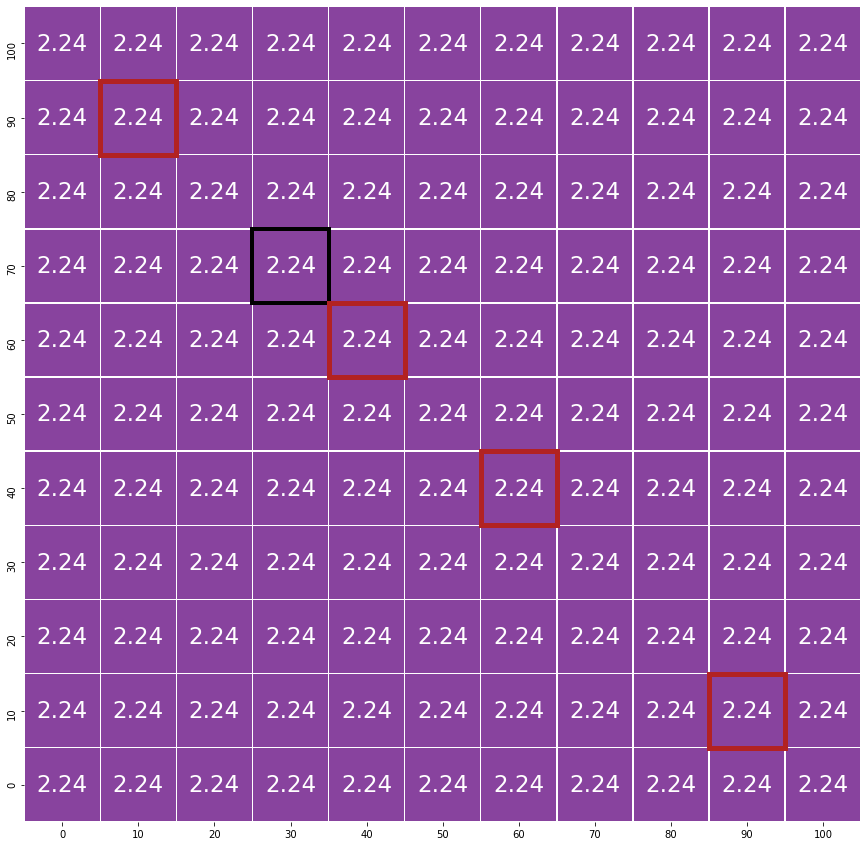

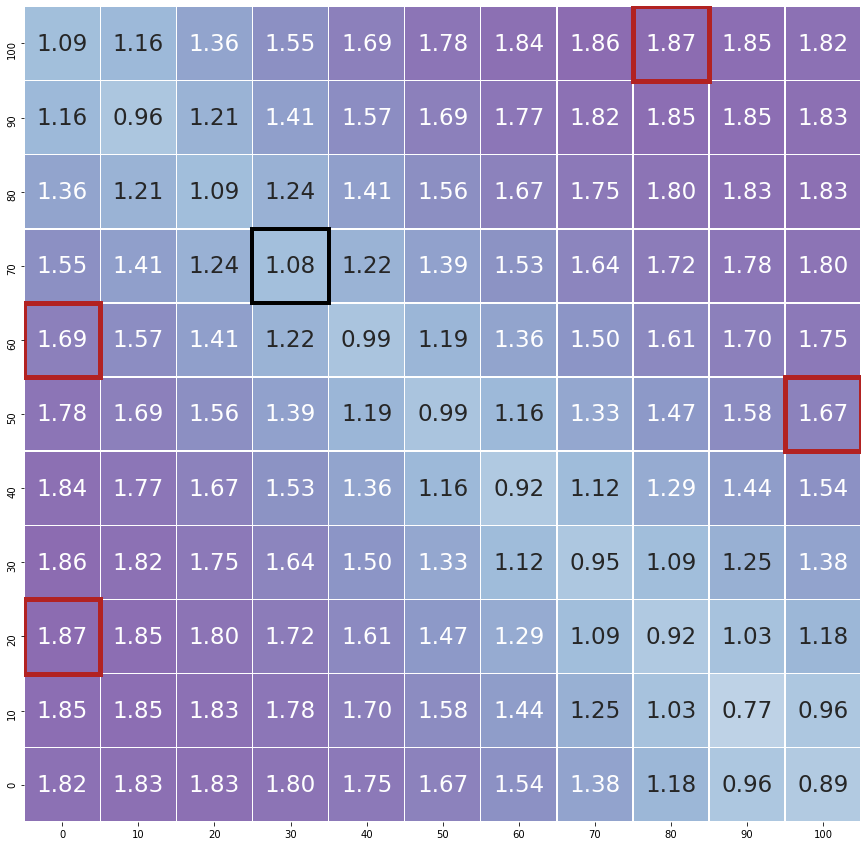

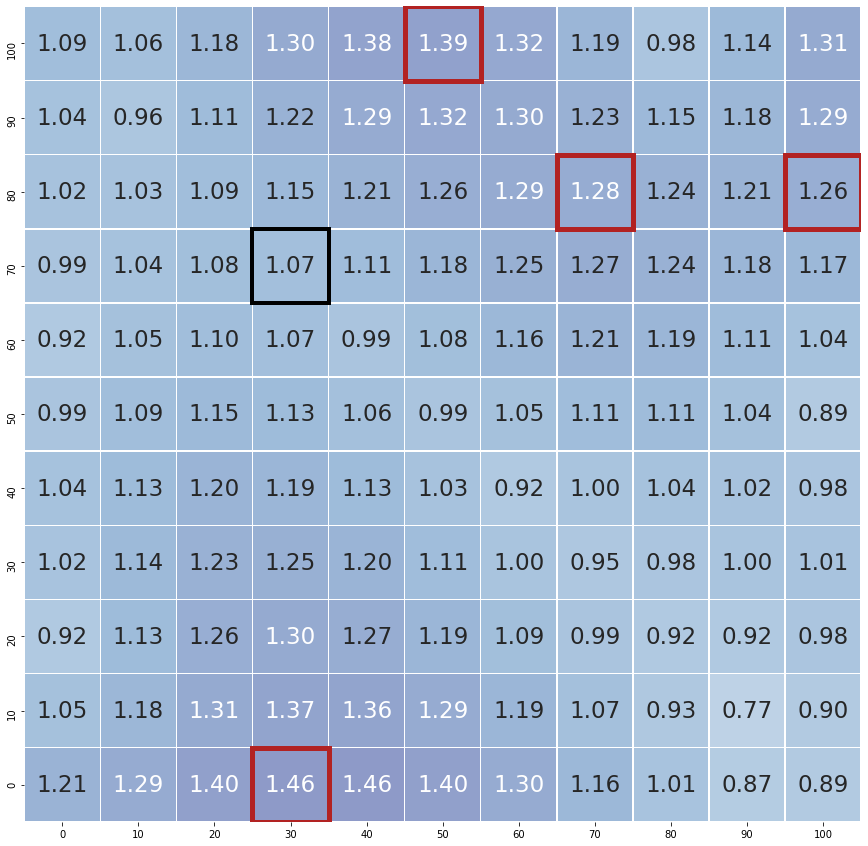

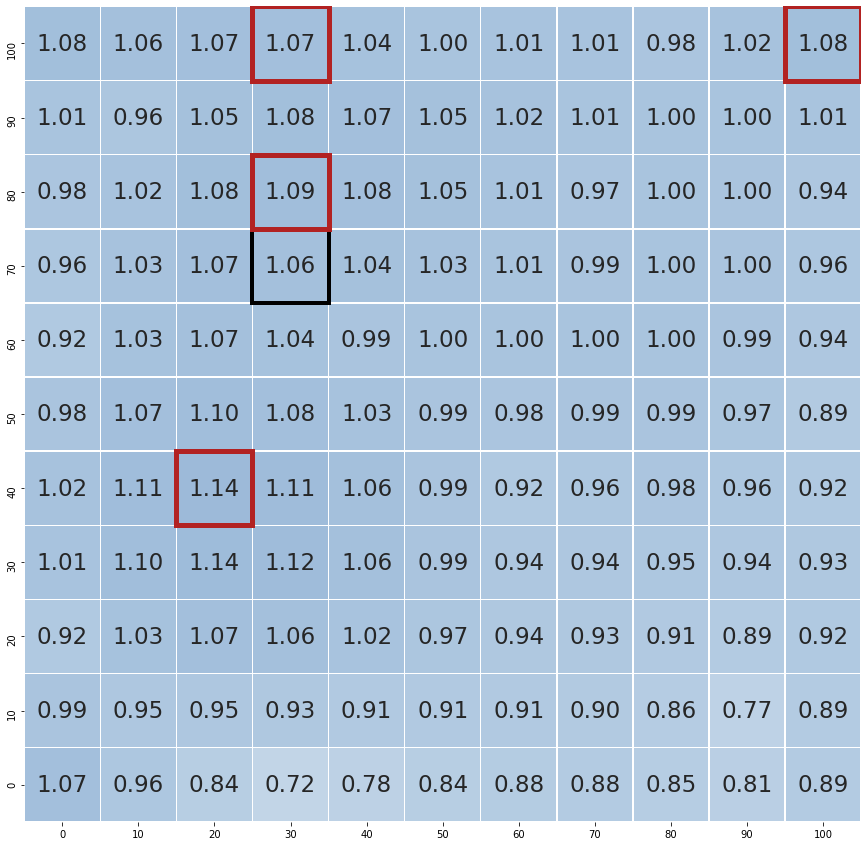

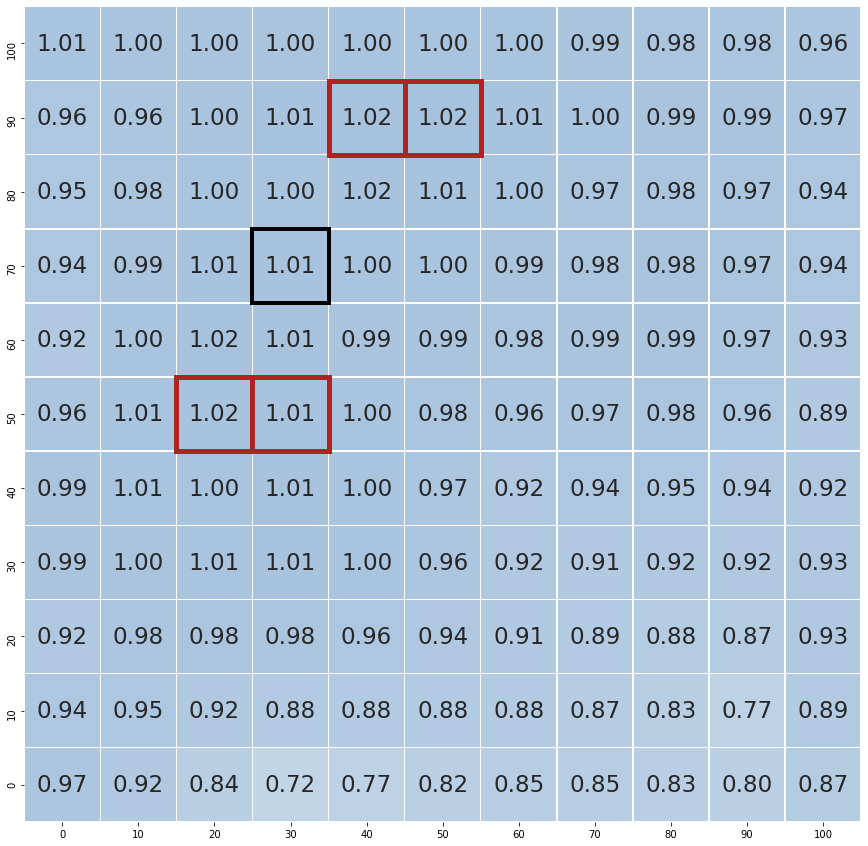

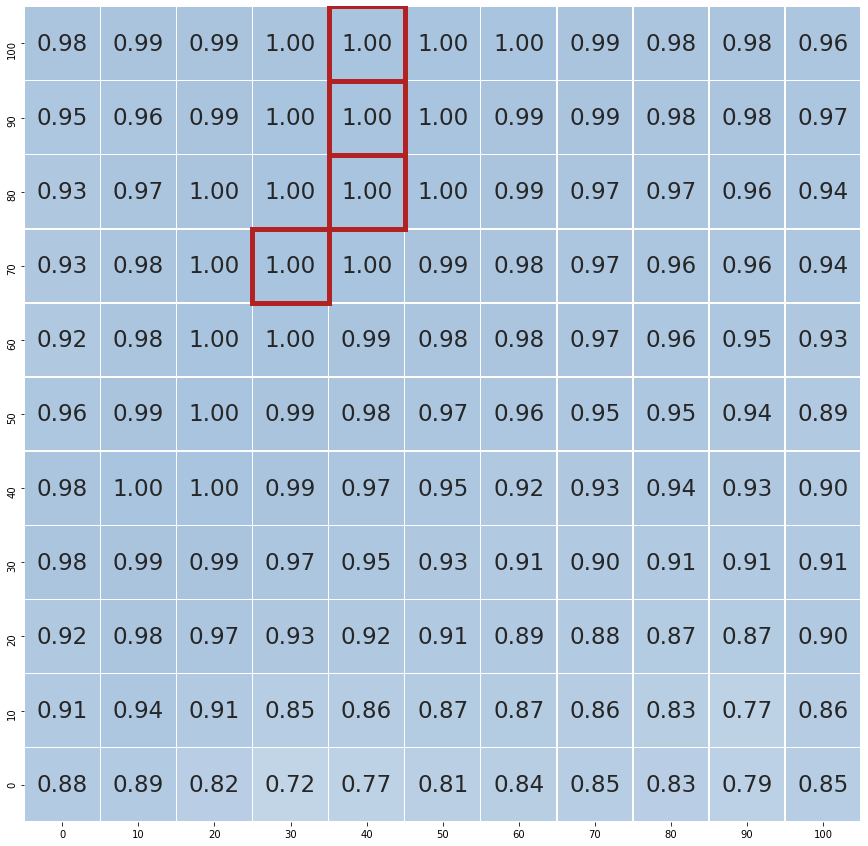

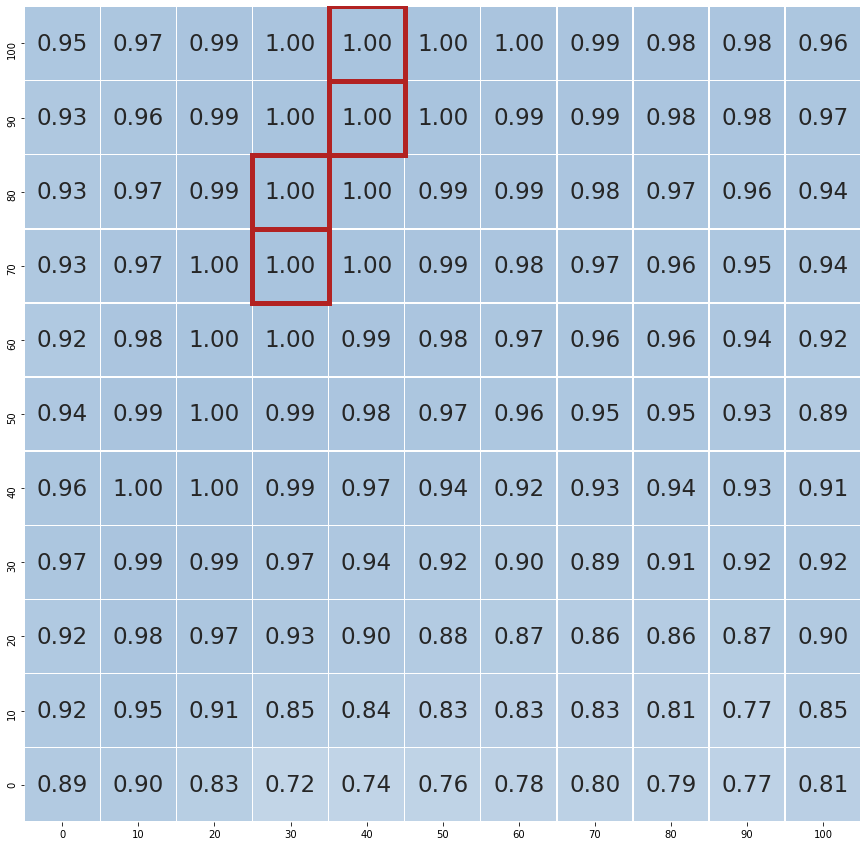

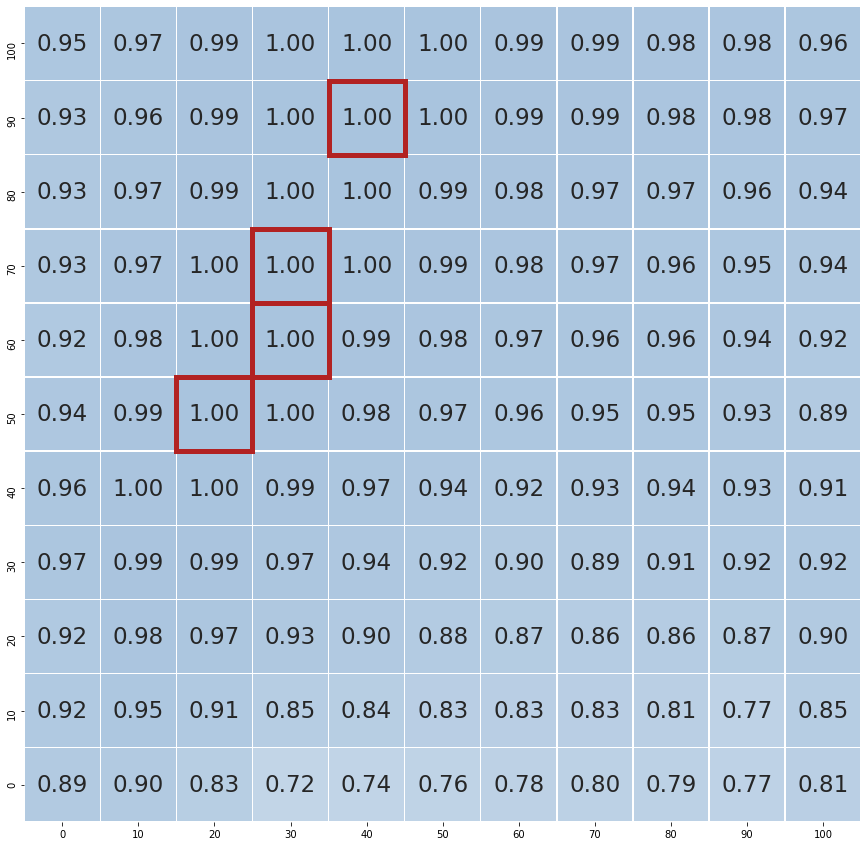

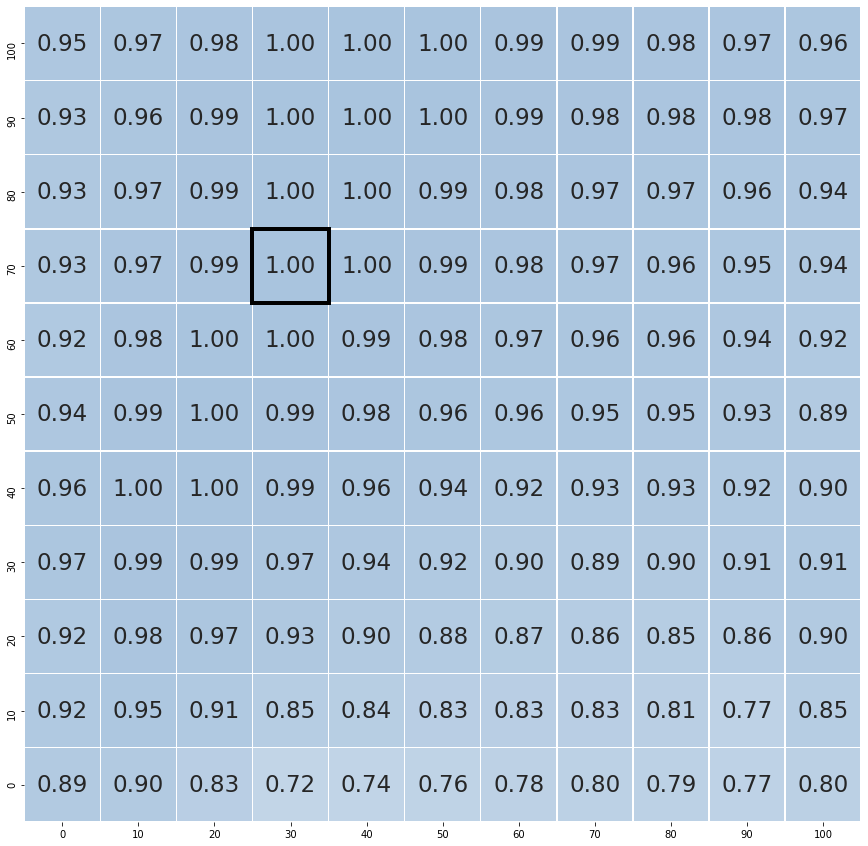

In [15]:
#Now plot target + 5 samples
X = np.array(agent2.X)

for i in range(len(mu1)):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sb.heatmap(mu2[i]+sig2[i]*math.sqrt(beta), 
                    cmap='BuPu',linewidths=.5, 
                    ax=ax, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=np.arange(0,101, 10),
                    yticklabels=np.flip(np.arange(0, 101, 10)),
                    #xticklabels=False,
                    #yticklabels=False,
                    vmin = 0,
                    vmax = 3,
                    cbar = False,
                    annot_kws={"size": 23}
                    )# xticklabels=False, yticklabels=False))
    ax.add_patch(Rectangle((3, 3), 1, 1, fill=False, edgecolor='black', lw=4))
    for j in range(batch_size):
        x = round(X[i*batch_size+j][0]*10)
        y = 10-round(X[i*batch_size+j][1]*10)
        ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='firebrick', lw=5))

In [ ]:
#Now plot target + 5 samples
X = np.array(agent1.X)

for i in range(len(mu1)):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sb.heatmap(mu1[i]+sig1[i]*math.sqrt(beta), 
                    cmap='BuPu',linewidths=.5, 
                    ax=ax, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=np.arange(0,101, 10),
                    yticklabels=np.flip(np.arange(0, 101, 10)),
                    #xticklabels=False,
                    #yticklabels=False,
                    vmin = 0,
                    vmax = 3,
                    cbar = False,
                    annot_kws={"size": 23}
                    )# xticklabels=False, yticklabels=False))
    ax.add_patch(Rectangle((3, 3), 1, 1, fill=False, edgecolor='black', lw=4))
    for j in range(batch_size):
        x = round(X[i][j][0]*10)
        y = 10-round(X[i][j][1]*10)
        ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='chartreuse', lw=5))

In [ ]:
X

In [ ]:
np.array(X)

In [ ]:
samples1 = np.array(agent1.X)
samples1

In [ ]:
data = agent1.X

for i in range(epochs):
    plt.figure()
    plt.plot(wavelength, target, c='black')
    for j in range(batch_size):
        spec = spectra_from_conc(data[i][j], RED, GREEN)
        plt.plot(wavelength, spec)

In [ ]:
mu1 = [agent1.mu]


sig1 = [agent1.sigma]


for i in range(epochs):
    agent1.learn()
    mu1.append(agent1.mu)
    sig1.append(agent1.sigma)

In [ ]:
for i in range(len(mu1)):
    plt.figure(figsize=(24,16))
    x = range(len(mu1[i]))
    plt.scatter(range(len(mu1[i])), mu1[i]+sig1[i])

In [ ]:
def spectra_from_conc(action, RED, GREEN, BLUE):
    """Transforms actions and input into output."""
    #action = normalize_to_fraction(action)
    spec = min_max(RED*action[0] + GREEN*action[1] + BLUE*action[2])
    return spec

def min_max(spectra):
    scaler = sklearn.preprocessing.MinMaxScaler()
    return scaler.fit_transform(spectra.reshape(-1,1)).reshape(1,-1)[0]


class Environment(object):
    def __init__(self, target, RED, GREEN, BLUE):
        # in future this will be basis spectra
        self.target = target
        self.RED = RED
        self.GREEN = GREEN
        self.BLUE = BLUE
        self.metric = []
   
    def get_cos_sim(self, target, y):
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
    
    def sample(self, action):
        # put functins in utils python file
        result = spectra_from_conc(action, self.RED, self.GREEN, self.BLUE)
        sim = self.get_cos_sim(self.target, result)
        mse = MSE(self.target, result)
        self.metric.append(sim)
        #return -mse
        return sim

In [ ]:
target_conc = [.2, .4, .4]
target_spectra = spectra_from_conc(target_conc, RED, GREEN, BLUE)
target = target_spectra

#constraints
min_conc = 0
max_conc = 1

# parameter space
N = 21 # grid size

# construct param space
coeffs = np.linspace(min_conc, max_conc, N)
param_space = np.meshgrid(coeffs, coeffs, coeffs)
epochs = 20
batch_size = 10

In [ ]:
kernel1 = RBF(1.0)
kernel3 = RBF()

env1 = Environment(target_spectra, RED, GREEN, BLUE)
env2 = Environment(target_spectra, RED, GREEN, BLUE)
env3 = Environment(target_spectra, RED, GREEN, BLUE)

agent1 = ucb.BatchGPUCBv2(batch_size, param_space, env1, beta=3)
agent2 = ucb.BatchGPUCBv2(batch_size, param_space, env2, beta=3, kernel=kernel1)
agent3 = ucb.BatchGPUCBv2(batch_size, param_space, env3, beta=3, kernel=kernel3)

In [ ]:
mu1 = []
sig1 = []
mu2 = []
sig2 = []
mu3 = []
sig3 = []

for i in range(epochs):
    agent1.learn()
    mu1.append(agent1.mu)
    sig1.append(agent1.sigma)
    agent2.learn()
    mu2.append(agent2.mu)
    sig2.append(agent2.sigma)
    agent3.learn()
    mu3.append(agent3.mu)
    sig3.append(agent3.sigma)

In [ ]:
data1 = agent1.X
data2 = agent2.X
data3 = agent3.X

fig, axs = plt.subplots(ncols=3, nrows=epochs, figsize=(12,20))


for i in range(epochs):
        axs[i][0].plot(wavelength, target, c='black')
        for j in range(batch_size):
            spec = spectra_from_conc(data1[i*batch_size+j], RED, GREEN, BLUE)
            axs[i][0].plot(wavelength, spec)
            
for i in range(epochs):
        axs[i][1].plot(wavelength, target, c='black')
        for j in range(batch_size):
            spec = spectra_from_conc(data2[i*batch_size+j], RED, GREEN, BLUE)
            axs[i][1].plot(wavelength, spec)
            
for i in range(epochs):
        axs[i][2].plot(wavelength, target, c='black')
        for j in range(batch_size):
            spec = spectra_from_conc(data3[i*batch_size+j], RED, GREEN, BLUE)
            axs[i][2].plot(wavelength, spec)

In [ ]:
for i in range(len(mu1)):
    plt.figure(figsize=(24,16))
    x = range(len(mu1[i]))
    plt.scatter(range(len(mu1[i])), mu1[i]+sig1[i])

In [ ]:
for i in range(len(mu2)):
    plt.figure(figsize=(24,16))
    x = range(len(mu2[i]))
    plt.scatter(range(len(mu2[i])), mu2[i]+sig2[i])